In [1]:
from PIL import Image
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from einops import rearrange, einsum

In [2]:
from patched_clip.patched_clip import CLIP_args, get_clip_embeddings, load_clip, save_clip_embeddings

In [3]:
from patched_clip import modified_clip

In [4]:
model, preprocess = load_clip()
device = 'cpu'

In [5]:
# text
class_list = ['chair', 'computer monitor', 'background', 'shelf', 'table', 'wall', 'floor']

text_inputs = torch.cat([modified_clip.tokenize(f"a photo of a {c}") for c in class_list]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=1, keepdim=True)

In [6]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x12d843060>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [7]:
image_paths = ['test.jpg']
device = 'cpu'

In [8]:
# CLIP_args.clip_model_name = CLIPArgs.model_type
# CLIP_args.device = device
high_res_feature = True

# Load images into pillow images
images = [Image.open(image_path) for image_path in image_paths]

# Get CLIP embeddings
with torch.no_grad():
    descriptors = get_clip_embeddings(images,
                                      to_cpu=False,
                                      model=model,
                                      preprocess=preprocess,
                                      skip_center_crop=high_res_feature)
    descriptors = descriptors.to(device)  # BCHW

ML_LOGGER_USER is not set. This is required for online usage.
timing <clip_preprocess_images>: 1.874E-01s
timing <get_clip_embeddings>: 1.072E+00s
clip_process_image_mean_time: 1.2609716669976478


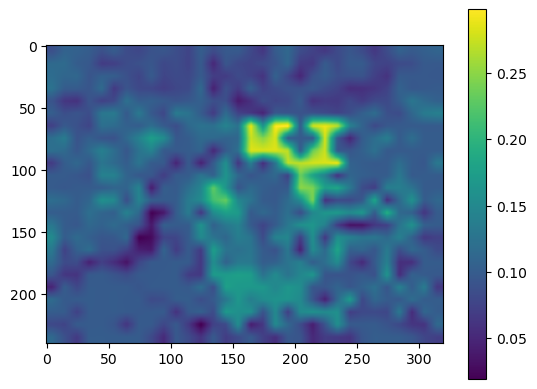

In [9]:
patch_features_bchw = descriptors / descriptors.norm(dim=1, keepdim=True)
similarity_mat_bhwc = einsum(patch_features_bchw, text_features, 'b c h w, d c -> b d h w')
similarity_mat_bhwc = F.interpolate(similarity_mat_bhwc, size=(240, 320), mode='bilinear', align_corners=False)
heatmap = similarity_mat_bhwc[0, 1, :, :].numpy()
plt.imshow(heatmap)
plt.colorbar()

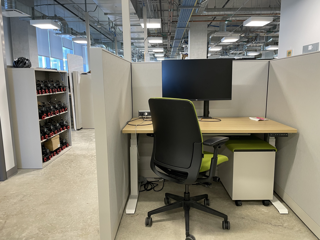

In [10]:
images[0].resize((320, 240))

In [11]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

image_tensors = []

for img in images:
    image_tensors.append(transform(img))

In [12]:
# Get CLIP embeddings
with torch.no_grad():
    descriptors = get_clip_embeddings(image_tensors,
                                      to_cpu=False,
                                      model=model,
                                      preprocess=preprocess,
                                      skip_center_crop=high_res_feature)
    descriptors = descriptors.to(device)  # BCHW

timing <get_clip_embeddings>: 1.069E+00s
clip_process_image_mean_time: 1.0770758330036188


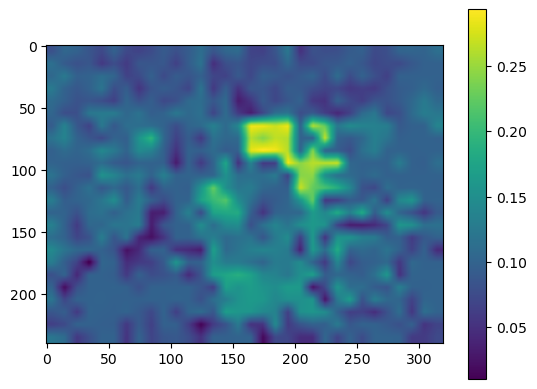

In [13]:
patch_features_bchw = descriptors / descriptors.norm(dim=1, keepdim=True)
similarity_mat_bhwc = einsum(patch_features_bchw, text_features, 'b c h w, d c -> b d h w')
similarity_mat_bhwc = F.interpolate(similarity_mat_bhwc, size=(240, 320), mode='bilinear', align_corners=False)
heatmap = similarity_mat_bhwc[0, 1, :, :].numpy()
plt.imshow(heatmap)
plt.colorbar()